# **Introdução Prática aos Principais Conceitos de Aprendizado de Máquina**

## Ao longo desta aula vamos nos familiarizar com a metodologia de Redes Neurais Profundas e Redes Convolucionais, trabalhar com as bibliotecas Keras e Tensorflow e realizar experimentos:

Basicamente, o que vimos até agora é que um  neurônio  (perceptron) ou  uma  camada de neurônios (no caso da  regressão  logística  multinomial) só  representam funções  linearmente separáveis. 

Redes de  múltiplas  camadas  solucionam  essa restrição. A utilização de  uma  camada intermediária  de neurônios com  neurônios  com  função  de ativação  não-linear  (sigmoidal ou  tangente hiperbólica),  que  fazem  combinações  não lineares das variáveis  de entrada, podem implementar superfícies  de decisão  mais  complexas. Assim, até  agora,  todas  as redes  com  as quais  trabalhamos tinham uma única  camada oculta  de  neurônios  (além  das camadas  de  entrada e saída):

![picture](https://drive.google.com/uc?export=view&id=10I0o1Z3k7vNdLvBXXM1RgA0JGr0_hijI)

No entanto, intuitivamente, esperamos que as redes com muito mais camadas ocultas sejam mais poderosas:

![picture](https://drive.google.com/uc?export=view&id=1JveQfeC4LmBgwoAgGSOT0UZfBwy0-K3V)

Tais redes poderiam usar as camadas intermediárias para construir múltiplas camadas de abstração, assim como fazemos em circuitos booleanos. Por exemplo, se estamos fazendo reconhecimento de padrões visuais, então os neurônios da primeira camada podem aprender a reconhecer bordas, os neurônios da segunda camada podem aprender a reconhecer formas mais complexas, digamos, triângulo ou retângulos, construídos a partir de bordas. A terceira camada reconheceria formas ainda mais complexas. E assim por diante. **Essas múltiplas camadas de abstração parecem propiciar às redes profundas uma vantagem convincente em aprender a resolver problemas complexos de reconhecimento de padrões.** 

Como podemos treinar essas redes profundas? Se tentaremos treinar redes profundas usando nosso algoritmo de aprendizado por gradiente descendente vamos nos deparar com problemas de aprendizado. No início, ao adicionarmos mais camadas de neurônios, o desempenho da rede aumenta. Mas, a medida que vamos adicionando mais e mais camadas ocultas, a desempenho começa a cair e degradar.

Se tentarmos entender o que está dificultando o treinamento de nossas redes profundas descobriremos que as diferentes camadas da nossa rede profunda estão aprendendo em velocidades muito diferentes. Em particular, quando as camadas posteriores da rede estão aprendendo bem, as camadas iniciais geralmente ficam presas durante o treinamento, aprendendo quase nada, ou vice-versa. Este fenômeno tem o nome de **Problema do Desaparecimento do Gradiente** (*The Gradient Vanishing Problem*). 

Existem algumas técnicas que podem nos ajudar a mitigar este problema de treinamento de redes neurais profundas. Por ora, vamos nos concentrar no uso de funções de ativação do tipo "**ReLU**" ou "**LeakyReLU**" como uma forma eficiente de enfrentar esta questão.

Vamos testar e treinar uma Rede Neural Profunda para os dados do MNIST.... 

## Em primeiro lugar, vamos importar as bibliotecas necessárias.

In [1]:
import numpy as np                                                     # ndarrys for gridded data
import pandas as pd                                                    # DataFrames for tabular data
import os                                                              # set working directory, run executables
import matplotlib.pyplot as plt                                        # for plotting
import matplotlib.image as mpimg 
import seaborn as sns    

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf              # Importa TF2
from tensorflow import keras         # Importa Keras
from tensorflow.keras import layers  # Ferramentes do Keras mais usadas para acesso mais rápido
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

print(tf.__version__)                # Deve retornar "2.0.0" ou versão mais recente



2.11.0


## Vamos preparar tudo para podermos ler os nossos arquivos de dados

Agora que estamos com tudo que precisamos carregado vamos ler os dados que estão na base de dados de números manuscritos MNIST. 

O objetivo aqui é ler a intensidade dos pixels que formam um dígito manuscrito entre 0 e 9 e treinar um modelo que seja capaz de classificar um dígito nunca visto.

##Carregando a Base de Dados

In [2]:
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.mnist.load_data()

print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Após carregar os dados, podemos ver que temos 60.000 casos para treinamento e 10.000 casos para teste do modelo (no caso, a rede neural)

## Montando a Rede Neural

Vamos montar agora a topologia da nossa Rede Neural Artificial Profunda.

- A entrada é determinada pela dimensão dos dados de entrada. Como a imagem dos dígitos está em uma grade de 28x28, isto significa que a entrada será um vetor de 784 = 28x28 que obtemos ao aplicar um layer.Flatten nos dados de entrada.

- A seguir vamos definir  **quatro camadas intermediárias** (hidden layer) com 30 neurônios em cada camada. 

- Por último, definimos a **camada de saída** (output layer) com 10 neurônios. 

[784 30 30 30 30 10]

### Fazendo o one-hot-encoding da variável de saída

In [4]:
num_classes = 10
ytrain = to_categorical(ytrain, num_classes)
ytest = to_categorical(ytest, num_classes)

## Montando o Modelo de Rede Neural

Para se criar um modelo é necessário primeiro criar uma instância de Sequential e adicionar camadas a ele com o comando add(). Nosso modelo tem **quatro** hidden layers de 30 neurônios e um output layer de 10 neurônios, um para cada dígito.

Observe que a **função de ativação** dos neurônios da **camada escondida** é **ReLU** e a função de ativação dos neurônios da **camada de saída** é softmax.

Antes de completarmos a "montagem" da rede neural que contrímos, definimos que o **método de treinamento** é o SGD (*Stochastic Gradient Descent*) com **taxa de aprendizado** = 0.05. 

No momento de "montar" ou "compilar" o modelo, definimos ainda a **função de custo** desejada (no caso, a entropia cruzada) e uma métrica de avaliação **qualitativa** do treinamento (no caso, a acurácia, ou seja, a percentagem de casos classificados corretamente em relação ao número total de casos).

In [5]:
def exp_decay(epoch):
   initial_lrate = 0.05
   k = 0.01
   lrate = initial_lrate * np.exp(-k*epoch)
   return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

modelo = tf.keras.Sequential()
modelo.add(layers.Flatten())
modelo.add(layers.Dense(30, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="relu"))
modelo.add(layers.Dense(30, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="relu"))
modelo.add(layers.Dense(30, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="relu"))
modelo.add(layers.Dense(30, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="relu"))
modelo.add(layers.Dense(10, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="softmax"))

opt = tf.keras.optimizers.SGD(learning_rate=0.9)
modelo.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

input_shape = Xtrain.shape
modelo.build(input_shape)

In [6]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (60000, 784)              0         
                                                                 
 dense (Dense)               (60000, 30)               23550     
                                                                 
 dense_1 (Dense)             (60000, 30)               930       
                                                                 
 dense_2 (Dense)             (60000, 30)               930       
                                                                 
 dense_3 (Dense)             (60000, 30)               930       
                                                                 
 dense_4 (Dense)             (60000, 10)               310       
                                                                 
Total params: 26,650
Trainable params: 26,650
Non-traina

## Criando um Conjunto de Validação

In [7]:
Xtr,Xval,ytr,yval = train_test_split(Xtrain,ytrain,test_size = 0.3)
num_train = np.size(Xtr,0)
print(num_train)

42000


## Treinando o Modelo

Agora que definimos um conjunto de dados para treinamento da rede, um conjunto de dados para validação, podemos **treinar** o nosso modelo usando a função **fit**. 

Vamos usar um  **batch_size** de 1000 e o número de iterações ou **épocas** do nosso algoritmo de gradiente descendente em 400.

Também usamos uma **taxa de decaimento exponencial** da learning_rate e um **earlystopping** quando o loss do conjunto de validação começar a subir por 20 épocas.

In [8]:
results = modelo.fit(Xtr, ytr, validation_data = (Xval, yval), batch_size = 1000, epochs=400, callbacks=[callback, lrate], verbose=1)


Epoch 1/400


2023-05-04 15:41:33.688690: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


42/42 [==============================] - 1s 5ms/step - loss: 2.2913 - accuracy: 0.1466 - val_loss: 2.2558 - val_accuracy: 0.1277 - lr: 0.0500
Epoch 2/400
42/42 [==============================] - 0s 3ms/step - loss: 1.9805 - accuracy: 0.2625 - val_loss: 1.7923 - val_accuracy: 0.3387 - lr: 0.0495
Epoch 3/400
42/42 [==============================] - 0s 3ms/step - loss: 1.3749 - accuracy: 0.4618 - val_loss: 0.8821 - val_accuracy: 0.6691 - lr: 0.0490
Epoch 4/400
42/42 [==============================] - 0s 3ms/step - loss: 0.9055 - accuracy: 0.6665 - val_loss: 0.5912 - val_accuracy: 0.8235 - lr: 0.0485
Epoch 5/400
42/42 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.8090 - val_loss: 0.4475 - val_accuracy: 0.8746 - lr: 0.0480
Epoch 6/400
42/42 [==============================] - 0s 3ms/step - loss: 0.4170 - accuracy: 0.8793 - val_loss: 0.3890 - val_accuracy: 0.8898 - lr: 0.0476
Epoch 7/400
42/42 [==============================] - 0s 3ms/step - loss: 0.3568 - accura

Depois da rede treinada, vamos agora visualizar em um gráfico como foi o desempenho do aprendizado ao longo das épocas. Plotamos a acurácia do modelo para os dados do conjunto de treinamento e do conjunto de teste. Do mesmo modo, plotamos o valor da função de custo ao longo das épocas.


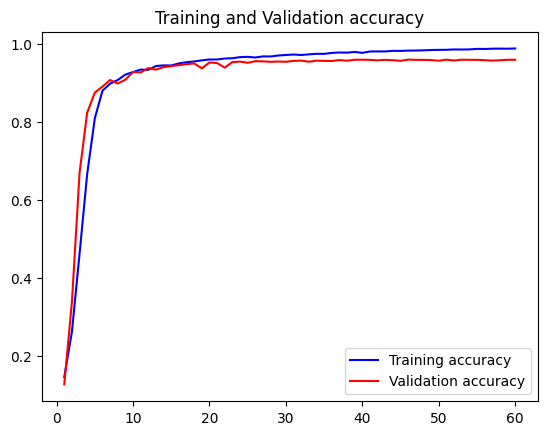

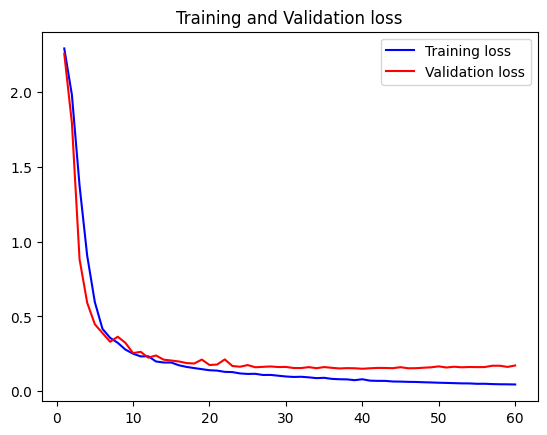

In [9]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label= 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Será que o desempenho desta rede com várias camadas foi melhor do que a rede de camada rasa que utilizamos na aula anterior para o mesmo problema do MNIST?

## Vamos observar o desempenho da Rede treinada para o Conjunto de Teste

313/313 [==============================] - 0s 298us/step

Accuracy: 0.9594



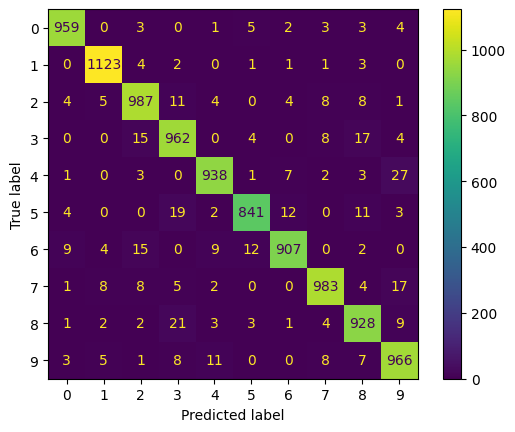

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

ytestpred = modelo.predict(Xtest)
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(ytest.argmax(axis=1), ytestpred.argmax(axis=1))))

#Your input to confusion_matrix must be an array of int not one hot encodings.
ConfusionMatrixDisplay.from_predictions(ytest.argmax(axis=1), ytestpred.argmax(axis=1))

# Redes Neurais Convolucionais

### Até aqui vimos que é possível usar redes neurais totalmente conectadas e em camadas para aplicações de classificação de imagens (p. ex.: reconhecimento de dígitos manuscritos – MNIST).

Em particular, no caso do MNIST,  para cada pixel na imagem de entrada, codificamos a intensidade do pixel como o valor para um neurônio correspondente na camada de entrada. 

Para as imagens de 28 × 28 pixels que estamos usando, isso significa que nossa rede possui 784 (= 28 × 28) neurônios de entrada. 

Em seguida, treinamos os pesos e os bias da rede para que a saída da rede identifique corretamente a imagem de entrada: '0', '1', '2', ..., '8' ou '9'.

Refletindo sobre este tipo de aplicação, podemos achar estranho usar redes com camadas totalmente conectadas para classificar imagens. 

## A razão é que tal arquitetura de rede não leva em consideração a estrutura espacial das imagens! 

Por exemplo, trata os pixels de entrada que estão distantes ou próximos uns dos outros exatamente no mesmo modo.  Tais conceitos de estrutura espacial devem ser inferidos dos próprios dados de treinamento. 

Mas e se, em vez de começar com uma arquitetura de rede que é tabula rasa, usamos uma arquitetura que tenta aproveitar e aprender a estrutura espacial (bordas, correlação espacial entre pixels, etc...)?



Uma Rede Convolucional é capaz de capturar com sucesso as dependências espaciais e temporais em uma imagem através da aplicação de filtros relevantes. A arquitetura executa um melhor ajuste ao conjunto de dados da imagem devido à redução no número de parâmetros envolvidos e à capacidade de reutilização dos pesos. Em outras palavras, a rede pode ser treinada para entender melhor a sofisticação da imagem.

Redes Neurais Convolucionais usam uma arquitetura especial particularmente adequada para classificar imagens. 
O uso desta arquitetura torna as redes convolucionais rápidas para treinar. 
Isso, por sua vez, nos ajuda a treinar redes profundas de várias camadas, que são muito boas na classificação de imagens. 
Atualmente, as redes convolucionais profundas ou algumas variantes próximas são usadas na maioria das redes neurais para o reconhecimento de imagens.

As redes neurais convolucionais usam três idéias básicas:

- campos receptivos locais, 
- pesos compartilhados e 
- pooling.

## Campos Receptivos Locais
Até aqui, as entradas foram retratadas como uma linha vertical de neurônios.

Em uma rede convolucional, fica mais fácil se pensarmos nas entradas como um quadrado de  A×L neurônios, cujos valores correspondem às intensidades de pixels que estamos usando como entradas:

![picture](https://drive.google.com/uc?export=view&id=1We6h1tb3OyJYemoIh8ZH4zcbgRFB7HIR)

Vamos conectar os pixels de entrada a uma camada de neurônios escondidos.

Mas não conectaremos cada pixel de entrada a cada neurônio escondido. Em vez disso, fazemos apenas conexões em pequenas regiões localizadas da imagem de entrada.

Para ser mais preciso, cada neurônio na primeira camada oculta será conectado a uma pequena região dos neurônios de entrada, digamos, por exemplo, uma região de 5 × 5 correspondendo a 25 pixels de entrada. 
Essa região na imagem de entrada é chamada de campo receptivo local para o neurônio oculto.

![picture](https://drive.google.com/uc?export=view&id=1nQJBciazy5rRTtK5s4NePWmr0aOjuIsR)

Nesta pequena janela nos pixels de entrada, cada conexão aprende um peso.

Podemos pensar nesse neurônio escondido particular como aprendendo a analisar seu campo receptivo local específico.

Em seguida, deslizamos o campo receptivo local em toda a imagem de entrada. 
Para cada campo receptivo local, existe um neurônio escondido diferente na primeira camada oculta.

![picture](https://drive.google.com/uc?export=view&id=17knIXpuaxJHzg-8IvaNS3HTKC6BDZ9lv)

Note que se tivermos uma imagem de entrada 28 × 28 e campos receptivos locais de 5 × 5, então haverá 24 × 24 neurônios na camada oculta. 

Isso ocorre porque só podemos mover o campo receptivo local 23 neurônios para o lado (ou 23 neurônios para baixo), antes de colidir com o lado direito (ou inferior) da imagem de entrada.

Algumas vezes é usado um comprimento de passo (“stride lenght”) diferente. Por exemplo, podemos mover o campo receptivo local 2 pixels para a direita (ou para baixo), caso em que diremos que um “stride lenght” de 2 é usado.

### O que o pequeno **Campo Receptivo** de 5x5 está fazendo em cada passo ao percorrer toda a imagem de entrada é o que chamamos de **CONVOLUÇÃO**. 

Os **pesos** do campo receptivo formam o que chamamos de **filtro**. 

Ao percorrer a imagem de entrada fazendo a convolução, o efeito do filtro é **"acender"** com mais intensidade na camada *hidden* aqueles neurônios que indicam onde, na imagem original, existem características que são semelhantes ao filtro. 

Para exemplificar, aqui temos um filtro que representa a curva ao seu lado.

![picture](https://drive.google.com/uc?export=view&id=1lXtO-f_0QRx_mpc6ZVsXY56rm3079Tja)


Na imagem a abaixo está destacado o campo receptivo no qual será multiplicado pelo filtro acima.

![picture](https://drive.google.com/uc?export=view&id=17pN6eQtl3tecDZ6j45v7q5FXDEE6CChW)

Com essa combinação temos como resultado um número alto, indicando uma compatibilidade entre as curvas. Quando a imagem não possui nenhuma compatibilidade esse resultado chega mais próximo a zero.

![picture](https://drive.google.com/uc?export=view&id=1I5ZaXb9NR_51Ln44uu97QIsOkvF88ajq)

Os filtros são ajustados na etapa de treinamento da rede neural convolucional  (Não é um ajuste/decisão manual).

O mapa da imagem de entrada para a camada oculta é chamado de **Mapa de Características** (*“Feature Map”*).

A estrutura descrita até agora é capaz de detectar apenas um único tipo de característica localizada. 

Além do tamanho do filtro e o stride da convolução como hiperparâmetro, quem está modelando uma CNN também tem que escolher como será o padding. O padding pode ser nenhum, no qual o output da convolução ficará no seu tamanho original, ou zero pad, onde uma borda é adicionada e preenchida com 0's. O padding serve para que as camadas não diminuam muito mais rápido do que é necessário para o aprendizado.

![picture](https://drive.google.com/uc?export=view&id=1qkLOSE_3GKqdQFuXzFViKWjCRjJ138dL)

Para fazer reconhecimento de imagens, precisaremos de mais do que um único feature map.

Assim, uma **Camada Convolucional** completa consiste em vários feature maps diferentes:

![picture](https://drive.google.com/uc?export=view&id=1HEGC8SRVHsl5y-qN1Ja3FoofC1b1S-p9)

##Pooling – Pooling Layers (agrupamento)

Além das camadas convolucionais que acabamos de descrever, as redes neurais convolucionais também contêm **Camadas de Pooling**. 

As camadas de pooling geralmente são usadas imediatamente após camadas convolucionais. 

O que as camadas de agrupamento fazem é simplificar a informação na saída da camada convolucional.

Uma camada de pooling agrupa um conjunto de saídas contígüas dos neurônios de um feature map da camada convolucional e gera um **mapa de carcaterístcas condensadas**, reduzindo a dimensionalidade (número de neurônios) do feature map.

Por exemplo, cada unidade na camada de pooling pode abranger uma região de (digamos) 2 × 2 neurônios na camada anterior. 

Como um exemplo concreto, um procedimento comum para o agrupamento é conhecido como pool máximo. No max-pooling, uma unidade de pooling simplesmente emite a ativação máxima na região de entrada de 2 × 2, conforme ilustrado no diagrama a seguir:

![picture](https://drive.google.com/uc?export=view&id=1H4_WwnWI4JIklHkzmKWclGEnNljBSIvs)

Podemos pensar no max-pooling como uma forma da rede perguntar se uma determinada característica pode ser  encontrada em algum lugar de uma região da imagem. 

Em seguida, a posição exata é descartada e apenas a posição aproximada é mantida. 

A intuição é que, uma vez que uma característica foi encontrada, sua localização exata não é tão importante quanto a sua localização relativa a outras características.

A grande vantagem é que vão existir um número bem menor da características agrupadas e isto vai ajudar a reduzir o número de parâmetros (pesos) necessários em camadas posteriores.

Agora podemos juntar todas essas ideias para formar uma rede neural convolucional completa.

Esta rede é semelhante às redes que já estávamos trabalhando mas, dependendo do problema a ser resolvido, podemos adicionar várias camadas convolucionais e de pooling. Ao final, adicionamos uma rede fully connected com neurônios soft-max na saída (se a aplicação for de classificação).

![picture](https://drive.google.com/uc?export=view&id=1YKGgSB-qjyXs5AILe2wbK19jpHm1hSno)

No caso do problema MNIST, serão 10 neurônios de saída, correspondente aos 10 valores possíveis para os dígitos MNIST ('0', '1', '2', etc.):

## Regularização em Redes Convolucionais - Dropout

Dropout é uma técnica radicalmente diferente para regularização. Ao contrário da Regularização L1 e L2, o Dropout não depende da modificação da função de custo. Em vez disso, no Dropout, modificamos a própria rede. 

O Dropout é uma técnica relativamente nova  que se fundamenta na eliminação aleatória de neurônios durante o processo de aprendizagem, para evitar a sobreadaptação aos dados (overfitting).

Na forma mais simples do dropout, durante o treinamento, a cada inserção de um novo vetor de dados na rede, ocorre a eliminação temporária de neurônios e respectivas ligações, com a probabilidade P (digamos P=0.5). Os neurônios que restarem após a eliminação são treinados usando o algoritmo de treinamento definido.Em seguida, repetimos o processo, primeiro restaurando os neurônios removidos, depois escolhendo um novo subconjunto aleatório de neurônios ocultos para excluir. 

Quando realmente executamos a rede completa, isso significa que mais neurônios ocultos estarão ativos. Para compensar isso, neste caso, reduzimos pela metade os pesos que saem dos neurônios ocultos.

![picture](https://drive.google.com/uc?export=view&id=19WpsjZxowYro-WLkBugRoytljYW9G9DH)

![picture](https://drive.google.com/uc?export=view&id=1UmRuLxRB9w4oH32bcjbAertS1ttqY5Mw)


### Você pode ler um material bem didático sobre Redes Convolucionais [aqui](https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184)

# Resolvendo com Rede Convolucional

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Make sure images have shape (28, 28, 1)
train_images = np.expand_dims(Xtr, -1)
val_images = np.expand_dims(Xval, -1)
test_images = np.expand_dims(Xtest, -1)
print("train images shape:", train_images.shape)
print(train_images.shape[0], "train samples")
print(test_images.shape[0], "test samples")



train images shape: (42000, 28, 28, 1)
42000 train samples
10000 test samples


In [ ]:
model_cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(120, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 32)         

In [ ]:
lr=0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)
# Compile the model.
model_cnn.compile(
  opt,
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 32)         

Epoch 1/100
329/329 [==============================] - 3s 8ms/step - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.0517 - val_accuracy: 0.9922
Epoch 2/100
329/329 [==============================] - 2s 6ms/step - loss: 0.0165 - accuracy: 0.9956 - val_loss: 0.0587 - val_accuracy: 0.9919
Epoch 3/100
329/329 [==============================] - 2s 7ms/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.0581 - val_accuracy: 0.9920
Epoch 4/100
329/329 [==============================] - 2s 6ms/step - loss: 0.0157 - accuracy: 0.9968 - val_loss: 0.0566 - val_accuracy: 0.9919
Epoch 5/100
329/329 [==============================] - 2s 7ms/step - loss: 0.0152 - accuracy: 0.9968 - val_loss: 0.0502 - val_accuracy: 0.9922
Epoch 6/100
329/329 [==============================] - 2s 6ms/step - loss: 0.0139 - accuracy: 0.9967 - val_loss: 0.0666 - val_accuracy: 0.9921
Epoch 7/100
329/329 [==============================] - 2s 7ms/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 0.0628 - val_accuracy: 0.9912

Text(0.5, 1.0, 'learning rate=0.001')

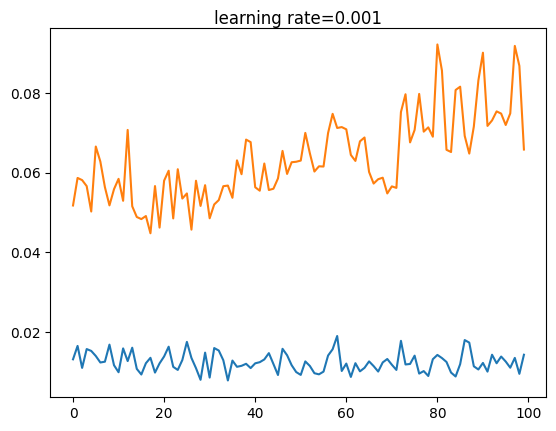

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

history = model_cnn.fit(
  train_images,
  ytr,
  epochs=100,
  batch_size=128,
  validation_data=(val_images, yval),
  verbose = 1,
  callbacks=[early_stop]
)

# plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('learning rate='+str(lr), pad=-80)

1313/1313 [==============================] - 2s 2ms/step

Accuracy: 0.9999



Text(0.5, 23.52222222222222, 'Predicted label')

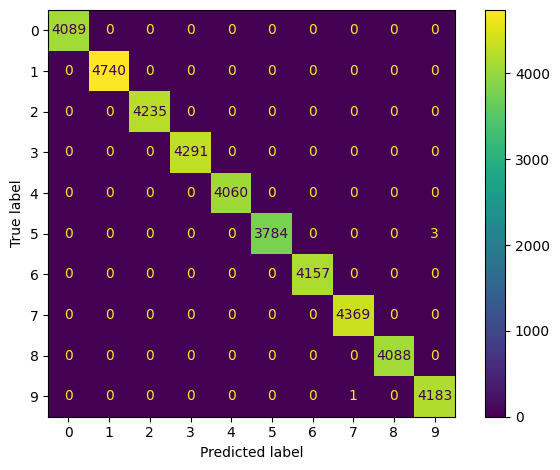

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

ytrainpred = model_cnn.predict(train_images)
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(ytr.argmax(axis=1), ytrainpred.argmax(axis=1))))

#Your input to confusion_matrix must be an array of int not one hot encodings.
ConfusionMatrixDisplay.from_predictions(ytr.argmax(axis=1), ytrainpred.argmax(axis=1))


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

313/313 [==============================] - 1s 2ms/step

Accuracy: 0.9921



Text(0.5, 23.52222222222222, 'Predicted label')

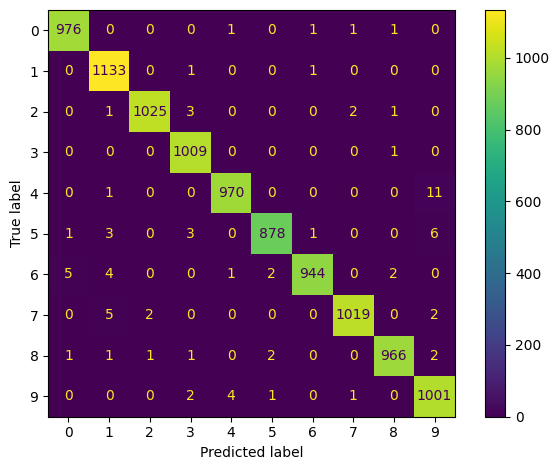

In [ ]:
ytestpred = model_cnn.predict(test_images)
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(ytest.argmax(axis=1), ytestpred.argmax(axis=1))))

#Your input to confusion_matrix must be an array of int not one hot encodings.
ConfusionMatrixDisplay.from_predictions(ytest.argmax(axis=1), ytestpred.argmax(axis=1))


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')